The goal of this tutorial is to use Pytorch to train a Deep Q Learning(DQN) agent on the `CartPole-v0` task from the OpenAI Gym.

# Import packages

In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

In [9]:
env = gym.make("CartPole-v0").unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/qianqu/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Replay Memory

Experience replay will help us to handle two things:
* Avoid forgetting previous experiences.
* Reduce correlations between experiences.



We need to classes:

* `Transition` - a tuple representing a single transition in our environment. It maps (state, action) pairs to their (next_state, reward)
* `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implement a `.sample()` method for selecting a random batch of transitions for training.

In [10]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

In [11]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    

# Q-network

Our Q-network would be a convolutional neural network that takes in the difference between the current and previous screen patches. 

In [12]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size=5,stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,32,kernel_size=5,stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            # calculate the output size of convolutional layer
            return (size - kernel_size) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_size = convw * convh * 32
        
        self.head = nn.Linear(linear_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        out = self.head(x.view(x.size(0),-1)) # x.size(0) is batch size
        return out

# Input extraction


It use `torchvision.transform` to compose image

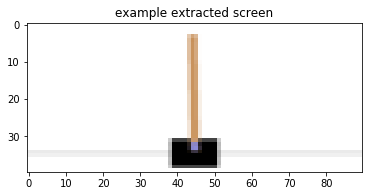

In [13]:
# first resize
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return_val = int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
    #print("get_cart_location: ", return_val)
    #print("scale", scale)
    #print("screen_width", screen_width)
    return return_val

def get_screen():
    # return screen requested by gym is 400*600*3
    
    # first change to torch order channel*height*width
    screen = env.render(mode="rgb_array").transpose((2, 0 ,1))
    _, screen_height, screen_width = screen.shape
    # in cartpole-v0, we can cut off the top and bottom of the screen
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    # now cut width
    view_width = int(screen_width*0.6)
    cart_location = get_cart_location(screen_width)
    # | --- | ---- | --- |
    #  0.3.   0.4.   0.3. 
    if cart_location < view_width//2:
        slice_range = slice(view_width) # start 0 end view_width
    elif cart_location > (screen_width - view_width//2):
        # act like list [-3:], get right part view_width length
        slice_range = slice(-view_width, None) 
    else:
        slice_range = slice(cart_location - view_width//2,
                           cart_location + view_width//2)
    screen = screen[:, :, slice_range]
    
    # conver to float, rescale to 0-1, to tensor, to device
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen).unsqueeze(0).to(device)
    
    return screen

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),
          interpolation='none')
plt.title('example extracted screen')
plt.show()
env.close()

In [14]:
env.state

array([ 0.01381454,  0.02752425, -0.01635903,  0.00264192])

# Training

## Hyperparameters and utilities

* `select_action`: select an action accordingly to an epsilon greedy policy. ie, at epsilon probability of randomly choose actions, the epsilon are decreasing as the learning processing. From `EPS_START` to `EPS_END`. `EPS_DECAY` controls the rate of the decay.

* `plot_durations`: helper function for plotting some informations.


In [15]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# get number of actions
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0



In [16]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START-EPS_END) * \
                    math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    


In [17]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episodes average and plot
    if len(durations_t) >= 100:
        means = durations_t.unfold(0,100,1).mean().view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
    plt.pause(0.001) # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

## training loop

Here, you can find an optimize_model function that performs a single step of the optimization. It first samples a batch, concatenates all the tensors into a single one, computes Q(st,at) and V(st+1)=maxaQ(st+1,a), and combines them into our loss. By defition we set V(s)=0 if s is a terminal state. We also use a target network to compute V(st+1) for added stability. The target network has its weights kept frozen most of the time, but is updated with the policy network’s weights every so often. This is usually a set number of steps but we shall use episodes for simplicity.

![image.png](./image.jpg)

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset the environment and initialize the state Tensor. Then, we sample an action, execute it, observe the next screen and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.

In [19]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>